### This is a notebook to format your data for segmentation, run the images through the cloud instance of Mesmer, and then extract marker counts and morphological information from all the cells in your images

In [1]:
# import required packages
import os
import warnings
import skimage.io as io
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import sys
import re
import pathlib
import csv
import skimage.io as io

from skimage.measure import regionprops_table
from skimage.morphology import remove_small_objects
from skimage.segmentation import find_boundaries
from skimage.exposure import rescale_intensity

# !{sys.executable} -m pip install google-api-python-client
# !{sys.executable} -m pip install google_auth_oauthlib

# FOR MORE INFORMATION: https://ark-analysis.readthedocs.io/en/stable/_markdown/ark.utils.html
from ark.utils import data_utils, deepcell_service_utils, io_utils, load_utils, io_utils, plot_utils, segmentation_utils

# FOR MORE INFORMATION: https://ark-analysis.readthedocs.io/en/stable/_markdown/ark.segmentation.html
from ark.segmentation import marker_quantification

from ark.utils import load_utils
from ark.utils import misc_utils

# plotting functions
from ark.utils.misc_utils import verify_in_list, verify_same_elements
from ark.utils.plot_utils import tif_overlay_preprocess

### All data, images, files, etc. must be placed in the 'data' directory, and referenced via '../data/path_to_your_data'

If you're interested in directly interfacing with Google Drive, consult the documentation [here](https://ark-analysis.readthedocs.io/en/latest/_rtd/google_docs_usage.html).

In [3]:
# set up file paths
base_dir = "../data/cell_to_segment_larger_dir/" #CHANGE TO YOUR PROPER DIRECTORY
input_dir = os.path.join(base_dir, "input_data") # ../data/cell_to_segment_smaller_dir/input_data
tiff_dir = os.path.join(input_dir, "single_channel_inputs/") # ../data/cell_to_segment_smaller_dir/input_data/single_channel_inputs/
deepcell_input_dir = os.path.join(input_dir, "deepcell_input/")
deepcell_output_dir = os.path.join(base_dir, 'deepcell_output')
single_cell_dir = os.path.join(base_dir, "single_cell_output")
viz_dir = os.path.join(base_dir, "deepcell_visualization")


In [4]:
# create directories if do not exist
for directory in [deepcell_input_dir, deepcell_output_dir, single_cell_dir, viz_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

### Here we are using the example data located in /data/example_dataset/input_data. To modify this notebook to run using your own data, simply change the base_dir to point to your own sub-directory within the data folder, rather than 'example_dataset'. 

In [5]:
# validate paths
io_utils.validate_paths([base_dir,
                         input_dir,
                         tiff_dir,
                         deepcell_input_dir,
                         deepcell_output_dir,
                         single_cell_dir,
                         viz_dir
                         ])

### compute and filter fov paths

In [6]:
# set this to true for multi-channel tiffs
MIBItiff = False

# data file suffix for low-level processed data
# only needed for MIBItiff = True
MIBItiff_suffix = "-MassCorrected-Filtered.tiff"

In [7]:
# either get all fovs in the folder...
if MIBItiff:
    fovs = io_utils.list_files(tiff_dir, substrs=MIBItiff_suffix)
else:
    fovs = io_utils.list_folders(tiff_dir)

    
#Note: List Folders does not list fovs in a sorted order which can cause issues down the road, hence sorting now! 
def atoi(text):
    if text.isdigit():
        return int(text)
    return text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


fovs.sort(key=natural_keys)
print(fovs)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov1", "fov2"]

# TODO: MIBItiff manual selection

['fov0', 'fov1', 'fov2', 'fov3', 'fov4', 'fov5', 'fov6', 'fov7', 'fov8', 'fov9', 'fov10', 'fov11', 'fov12', 'fov13', 'fov14', 'fov15', 'fov16', 'fov17', 'fov18', 'fov19', 'fov20', 'fov21', 'fov22', 'fov23', 'fov24', 'fov25', 'fov26', 'fov27', 'fov28', 'fov29', 'fov30', 'fov31', 'fov32', 'fov33', 'fov34', 'fov35', 'fov36', 'fov37', 'fov38', 'fov39']


### load images into notebook, process, and save as Mesmer compatable input

In [8]:
# NOTE: at least one of nucs and mems must not be None
# nuclear channel name(s) (or nucs = None)
nucs = ['DAPI']

# membrane channel name(s) (or mems = None)
mems = ['CD8','CD4','CD163','CD3']

In [9]:
# generate and save deepcell input tifs
# set img_sub_folder param to None if the image files in tiff_dir are not in a separate sub folder 
data_utils.generate_deepcell_input(
    deepcell_input_dir,
    tiff_dir,
    nucs,
    mems,
    fovs,
    is_mibitiff=False,
    img_sub_folder="TIFs",
    batch_size=5
)

#This function takes each fov directory in single_channel_inputs and creates a single tiff file in input_data/deelcell_input_data

/usr/local/lib/python3.6/site-packages/ark/utils/load_utils.py:174: UserWarning: The supplied non-float dtype int16 was overwritten to float64, because the loaded images are floats
  warnings.warn(f"The supplied non-float dtype {dtype} was overwritten to {data_dtype}, "


## Upload files to Deepcell and download results

Deepcell input images will be zipped into a single file, uploaded to [deepcell.org](https://deepcell.org),

and the output will be downloaded to the deepcell output directory.

In [10]:
# Mesmer was trained on data acquired at 20X resolution. If your image data was acquired at a different resolution, you will get the best performance by rescaling. The rescale factor will increase or decrease the image resolution by the value you provide. For example, if you data was acquired at 10X, use a `rescale_factor` of 2. If your data was acquired at 60X resolution, use a `rescale_factor` of 0.33.
rescale_factor = 1.0

In [11]:
deepcell_service_utils.create_deepcell_output(deepcell_input_dir, deepcell_output_dir, fovs=fovs, scale=rescale_factor)
#This takes the deepcell input and then adds the segmentation in the deep_cell_output

Processing tiffs in 1 batches...
Zipping preprocessed tif files.
Uploading files to DeepCell server.
Segmentation progress:


  0%|          | 0/100 [00:00<?]

Extracting tif files from DeepCell response.


### We can then save the segmented mask overlaid on the imaging data

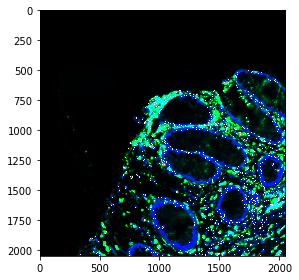

In [12]:
# display the channel overlay for a fov, useful for quick verification
warnings.simplefilter("ignore")

fov_to_display = io_utils.remove_file_extensions([fovs[0]])[0]

fov_overlay = plot_utils.create_overlay(
    fov=fov_to_display,
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    img_overlay_chans=['nuclear_channel', 'membrane_channel'],
    seg_overlay_comp='whole_cell'
)

io.imshow(fov_overlay)

In [13]:

# save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir)
#For each fov, generates segmentation labels, segmentation borders, and overlays over the channels if specified.
#These will be added to the deepcell_visulation directory
def save_segmentation_labels(segmentation_dir, data_dir, output_dir,
                             fovs, channels=None):
    """For each fov, generates segmentation labels, segmentation borders, and overlays
    over the channels if specified.

    Saves overlay images to output directory

    Args:
        segmentation_dir (str):
            Path to the directory containing segmentation labels
        data_dir (str):
            Path to the directory containing the image data
        output_dir (str):
            path to directory where the output will be saved
        fovs (list):
            list of FOVs to subset in segmentation_labels_xr
        channels (list):
            list of channels to subset in segmentation_labels_xr
    """

    for fov in fovs:
        # read the segmentation data in
        labels = load_utils.load_imgs_from_dir(data_dir=segmentation_dir,
                                               files=[fov + '_feature_0.tif'],
                                               xr_dim_name='compartments',
                                               xr_channel_names=['whole_cell'],
                                               trim_suffix='_feature_0',
                                               match_substring='_feature_0',
                                               force_ints=True)

        # generates segmentation borders and labels
        labels = labels.loc[fov, :, :, 'whole_cell'].values

        # save the labels respectively
        save_path_seg_labels = os.path.join(output_dir, f'{fov}_segmentation_labels.tiff')
        io.imsave(save_path_seg_labels, labels, plugin='tifffile', check_contrast=False)

        # define borders of cells in mask
        contour_mask = find_boundaries(labels, connectivity=1, mode='inner').astype(np.uint8)
        contour_mask[contour_mask > 0] = 255

        # save the cell border image
        save_path_seg_borders = os.path.join(output_dir, f'{fov}_segmentation_borders.tiff')
        io.imsave(save_path_seg_borders, contour_mask, plugin="tifffile", check_contrast=False) #BUG FOUND!

        # generate the channel overlay if specified
        if channels is not None:
            # chans needs to be a numpy array so *chans.astype('str') can work properly
            chans = np.array(channels)

            # create a channel overlay for the fov with the provided channels
            channel_overlay = plot_utils.create_overlay(
                fov=fov, segmentation_dir=segmentation_dir, data_dir=data_dir,
                img_overlay_chans=chans, seg_overlay_comp='whole_cell'
            )

            # save the channel overlay

            save_path = '_'.join([f'{fov}', *chans.astype('str'), 'overlay.tiff'])
            save_path_channel = os.path.join(output_dir, save_path)
            io.imsave(save_path_channel, channel_overlay, plugin="tifffile", check_contrast=False)


In [14]:
save_segmentation_labels(
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=viz_dir,
    fovs=io_utils.remove_file_extensions(fovs)
)

### Afterwards, we can generate expression matrices from the labeling + imaging data

In [15]:
# set to True to add nuclear cell properties to the expression matrix
nuclear_counts = False

### First we will generate the segmentation labels and borders into images. Then we will save that into a npy file to be loaded at a later time. Outpu is single_cell_output/

In [16]:
# generates segmentation borders and labels
segmentation_labels = load_utils.load_imgs_from_dir(data_dir=deepcell_output_dir,
                                               files=[fov + '_feature_0.tif' for fov in fovs],
                                               xr_dim_name='compartments',
                                               xr_channel_names=['whole_cell'],
                                               trim_suffix='_feature_0',
                                               match_substring='_feature_0',
                                               force_ints=True)


segmentation_boundaries = load_utils.load_imgs_from_dir(data_dir=viz_dir,
                                               files=[fov + '_segmentation_borders.tiff' for fov in fovs],
                                               xr_dim_name='compartments',
                                               xr_channel_names=['whole_cell'],
                                               trim_suffix='_segmentation_borders',
                                               match_substring='_segmentation_borders',
                                               force_ints=True)


In [17]:
#Get the cell_file_name so we can easily see and use the output
base_dir_split = base_dir.split('/')
if(base_dir_split[-1]):
    cell_file_name = base_dir_split[-1][:-4] #if no ending /
else:
    cell_file_name = base_dir_split[-2][:-4] # if there is a ending / 


In [18]:
np.save(os.path.join(single_cell_dir, f"segmentation_labels_current-{cell_file_name}.npy"), segmentation_labels)
np.save(os.path.join(single_cell_dir, f"segmentation_borders_current-{cell_file_name}.npy"), segmentation_boundaries)

### Next we will create the cell_table csv file with all information

In [19]:
#In order to generate_cell_table, the fovs must all contain some cells. If there is no cells, an index out of range error occurs in marker_quantification.generate_cell_table
non_empty_fovs = []
for idx, fov in enumerate(segmentation_labels):
    if(np.any(fov)): #if it doesnt have all zeroes aka no cells
        non_empty_fovs.append('fov' + str(idx))


For a full list of features extracted, please refer to the cell table section of: https://ark-analysis.readthedocs.io/en/latest/_rtd/data_types.html

In [21]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=deepcell_output_dir,
                                              tiff_dir=tiff_dir, #input_data/single_channel_inputs
                                              img_sub_folder="TIFs",
                                              is_mibitiff=MIBItiff,
                                              fovs=non_empty_fovs,
                                              batch_size=5,
                                              nuclear_counts=nuclear_counts)
# Deepell ark pipeline, if one of the FOV has no cells in it, and it will still try to exract intensity info from teh cells, and added in a (issue to the page), skip over cells

extracting data from fov0
extracting data from fov1
extracting data from fov10
extracting data from fov11
extracting data from fov12
extracting data from fov13
extracting data from fov14
extracting data from fov15
extracting data from fov16
extracting data from fov17
extracting data from fov18
extracting data from fov19
extracting data from fov2
extracting data from fov20
extracting data from fov21
extracting data from fov22
extracting data from fov23
extracting data from fov24
extracting data from fov25
extracting data from fov26
extracting data from fov27
extracting data from fov28
extracting data from fov29
extracting data from fov3
extracting data from fov30
extracting data from fov31
extracting data from fov32
extracting data from fov33
extracting data from fov34
extracting data from fov36
extracting data from fov37
extracting data from fov38
extracting data from fov5
extracting data from fov6
extracting data from fov7
extracting data from fov8
extracting data from fov9


In [22]:
# save extracted data as csv for downstream analysis
cell_table_size_normalized.to_csv(os.path.join(single_cell_dir, f'cell_table_size_normalized-{cell_file_name}.csv'),
                                 index=False)

cell_table_arcsinh_transformed.to_csv(os.path.join(single_cell_dir, f'cell_table_arcsinh_transformed-{cell_file_name}.csv'),
                                     index=False)

In [23]:
#We have the entire cell data for each tile spread out. In order to have it in a more usable format, we will stich it together as the cell should be!

def stich_cell_data(segmented_cell_dir, cell_file_name, plot_stitch=False):
    tile_position_metadata_path = pathlib.Path(f"{segmented_cell_dir}/tile_metadata.txt")
    single_cell_table_output_path = pathlib.Path(f"{segmented_cell_dir}/single_cell_output/cell_table_arcsinh_transformed-{cell_file_name}.csv"
                                         )
    cell_data = pd.read_csv(single_cell_table_output_path)
    with open(tile_position_metadata_path, newline='') as csvfile:
        tile_position_data = csv.DictReader(csvfile)
        for tile_pos_row in tile_position_data:
            # Grab all centroid x & y values in specified fov
            xvals = cell_data[cell_data.fov == tile_pos_row['fov']]['centroid-0'].values
            yvals = cell_data[cell_data.fov == tile_pos_row['fov']]['centroid-1'].values

            xvals += float(tile_pos_row['x1'])
            yvals += float(tile_pos_row['y1'])

            cell_data.loc[cell_data.fov == tile_pos_row['fov'],'centroid-0'] = xvals
            cell_data.loc[cell_data.fov == tile_pos_row['fov'],'centroid-1'] = yvals

            if(plot_stitch):
                plt.scatter(xvals, yvals)
                plt.text(np.mean(xvals), np.mean(yvals), tile_pos_row['fov'])
        if plot_stitch: plt.show()
    cell_data.to_csv(f"{segmented_cell_dir}/single_cell_output/cell_table_arcsinh_transformed_stitched-{cell_file_name}.csv")


In [26]:
stich_cell_data(base_dir, cell_file_name)

## Finally, we can create an optional final tiff overlay. 

In [27]:
def calculate_final_dimensions_from_metadata(tile_metadata_file_path):
    with open(tile_metadata_file_path, newline='') as metadata_file_path:
        tile_position_data = csv.DictReader(metadata_file_path)
        final_dimensions = metadata_file_path.readlines()[-1].split(',')
        rows = len(np.arange(0, int(final_dimensions[2]), 2048))  #final x dimension
        cols = len(np.arange(0, int(final_dimensions[4]), 2048))  #final y dimensions
        return rows, cols


In [28]:
def generate_pre_tif_and_mask_for_overlay(fov, segmentation_dir, data_dir, img_overlay_chans, seg_overlay_comp,dtype='int16'):
    
    # load the specified fov data in
    plotting_tif = load_utils.load_imgs_from_dir(
        data_dir=data_dir,
        files=[fov + '.tif'],
        xr_dim_name='channels',
        xr_channel_names=['nuclear_channel', 'membrane_channel'],
        dtype=dtype
    )

    # verify that the provided image channels exist in plotting_tif
    misc_utils.verify_in_list(
        provided_channels=img_overlay_chans,
        img_channels=plotting_tif.channels.values
    )

    # subset the plotting tif with the provided image overlay channels
    plotting_tif = plotting_tif.loc[fov, :, :, img_overlay_chans].values


    # read the segmentation data in
    segmentation_labels_cell = load_utils.load_imgs_from_dir(data_dir=segmentation_dir,
                                                             files=[fov + '_feature_0.tif'],
                                                             xr_dim_name='compartments',
                                                             xr_channel_names=['whole_cell'],
                                                             trim_suffix='_feature_0',
                                                             match_substring='_feature_0',
                                                             force_ints=True)

    segmentation_labels_nuc = load_utils.load_imgs_from_dir(data_dir=segmentation_dir,
                                                            files=[fov + '_feature_1.tif'],
                                                            xr_dim_name='compartments',
                                                            xr_channel_names=['nuclear'],
                                                            trim_suffix='_feature_1',
                                                            match_substring='_feature_1',
                                                            force_ints=True)

    segmentation_labels = xr.DataArray(np.concatenate((segmentation_labels_cell.values,
                                                      segmentation_labels_nuc.values),
                                                      axis=-1),
                                       coords=[segmentation_labels_cell.fovs,
                                               segmentation_labels_cell.rows,
                                               segmentation_labels_cell.cols,
                                               ['whole_cell', 'nuclear']],
                                       dims=segmentation_labels_cell.dims)

    # verify that the provided segmentation channels exist in segmentation_labels
    misc_utils.verify_in_list(
        provided_compartments=seg_overlay_comp,
        seg_compartments=segmentation_labels.compartments.values
    )
    
    # subset segmentation labels with the provided segmentation overlay channels
    segmentation_labels = segmentation_labels.loc[fov, :, :, seg_overlay_comp].values
    # overlay the segmentation labels over the image
    plotting_tif = tif_overlay_preprocess(segmentation_labels, plotting_tif)

    # define borders of cells in mask
    predicted_contour_mask = find_boundaries(segmentation_labels,
                                             connectivity=1, mode='inner').astype(np.uint8)
    predicted_contour_mask[predicted_contour_mask > 0] = 255
    return plotting_tif, predicted_contour_mask


def generate_stitched_overlay(fovs, segmentation_dir, data_dir,
                           img_overlay_chans, seg_overlay_comp, alternate_segmentation=None,
                           dtype='int16'):
    
    rows, cols = calculate_final_dimensions_from_metadata(pathlib.Path(base_dir,'tile_metadata.txt'))
    final_concat_plotting_tif = None
    final_concat_contour_mask = None
    
    for i in range(rows):        
        plotting_tif, predicted_contour_mask = generate_pre_tif_and_mask_for_overlay(fovs[i * cols], segmentation_dir, data_dir, img_overlay_chans, seg_overlay_comp)
        print(f"Creating & stitching overlay for {fovs[i*cols]}")
        
        for j in range(1, cols):
            fov = fovs[i*cols+j]
            print(f"Creating & stitching overlay for {fov}")

            plotting_tif_inner, predicted_contour_mask_inner = generate_pre_tif_and_mask_for_overlay(fovs[i * cols + j], segmentation_dir, data_dir, img_overlay_chans, seg_overlay_comp)

            plotting_tif = np.concatenate([plotting_tif, plotting_tif_inner], axis=1)
            predicted_contour_mask = np.concatenate([predicted_contour_mask, predicted_contour_mask_inner], axis=1)

        if(i == 0):
            final_concat_plotting_tif = plotting_tif
            final_concat_contour_mask = predicted_contour_mask
        else:
            final_concat_plotting_tif =  np.concatenate([final_concat_plotting_tif, plotting_tif], axis=0)
            final_concat_contour_mask =  np.concatenate([final_concat_contour_mask, predicted_contour_mask], axis=0)

    # rescale each channel to go from 0 to 255
    rescaled = np.zeros(final_concat_plotting_tif.shape, dtype='uint8')

    for idx in range(final_concat_plotting_tif.shape[2]):
        if np.max(final_concat_plotting_tif[:, :, idx]) == 0:
            # don't need to rescale this channel
            pass
        else:
            percentiles = np.percentile(final_concat_plotting_tif[:, :, idx][final_concat_plotting_tif[:, :, idx] > 0],
                                        [5, 95])
            rescaled_intensity = rescale_intensity(final_concat_plotting_tif[:, :, idx],
                                                   in_range=(percentiles[0], percentiles[1]),
                                                   out_range='uint8')
            rescaled[:, :, idx] = rescaled_intensity

    # overlay first contour on all three RGB, to have it show up as white border
    rescaled[final_concat_contour_mask > 0, :] = 255

    return rescaled

Creating & stitching overlay for fov0
Creating & stitching overlay for fov1
Creating & stitching overlay for fov2
Creating & stitching overlay for fov3
Creating & stitching overlay for fov4
Creating & stitching overlay for fov5
Creating & stitching overlay for fov6
Creating & stitching overlay for fov7
Creating & stitching overlay for fov8
Creating & stitching overlay for fov9
Creating & stitching overlay for fov10
Creating & stitching overlay for fov11
Creating & stitching overlay for fov12
Creating & stitching overlay for fov13
Creating & stitching overlay for fov14
Creating & stitching overlay for fov15
Creating & stitching overlay for fov16
Creating & stitching overlay for fov17
Creating & stitching overlay for fov18
Creating & stitching overlay for fov19
Creating & stitching overlay for fov20
Creating & stitching overlay for fov21
Creating & stitching overlay for fov22
Creating & stitching overlay for fov23
Creating & stitching overlay for fov24
Creating & stitching overlay for fo

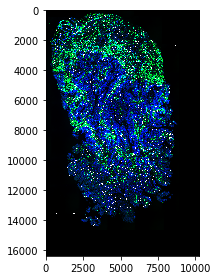

In [29]:
# display the channel overlay for a fov, useful for quick verification
warnings.simplefilter("ignore")

fov_overlay = generate_stitched_overlay(
    fovs=fovs,
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    img_overlay_chans=['nuclear_channel', 'membrane_channel'],
    seg_overlay_comp='whole_cell'
)

io.imshow(fov_overlay)

In [34]:
fov_overlay_changed = np.array(fov_overlay, dtype='int32')
print(type(fov_overlay), fov_overlay.shape, fov_overlay.dtype)

<class 'numpy.ndarray'> (16384, 10240, 3) uint8


In [36]:
!{sys.executable} -m pip install tifffile
import tifffile as tf

# tf.imwrite(str(pathlib.Path(deepcell_output_dir ,f"final_overlay-{cell_file_name}.tiff")), fov_overlay_changed)
tf.imwrite(str(pathlib.Path("../data/" ,f"final_overlay-{cell_file_name}.tiff")), fov_overlay_changed)

#NOTE: This image might be massive, and cannot be viewed in normal way. Use something like imagej/fiji to view it. 

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [ ]:
#Bugs found: 
    #1. segmentation_utils.save_segmentation_labels line 229 
    #2. generate_cell_table does not work on empty fov